In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sbn

import warnings
warnings.simplefilter("ignore")

In [5]:
accs = pd.read_csv("lr_acc.csv", names=["k", "lr_acc"])
accs

,k,lr_acc
0,1,0.508475
1,2,0.430508
2,3,0.410169
3,4,0.379661
4,5,0.366102
...,...,...
95,96,0.372881
96,97,0.372881
97,98,0.372881
98,99,0.372881


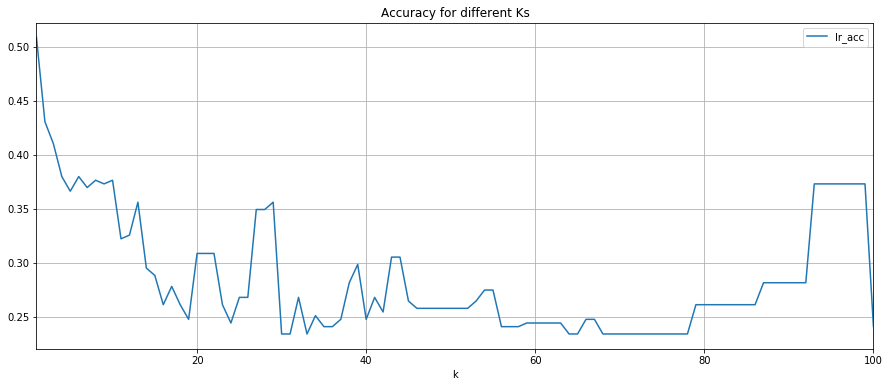

In [8]:
accs.plot("k", "lr_acc", figsize=(15,6), grid=True, title="Accuracy for different Ks")